# Parsing. Syntax


## Syntax tree

In [1]:
import nltk
from nltk import pos_tag, word_tokenize, RegexpParser

In [2]:
def create_syntax_tree(sentence):
    # Find all parts of speech in sentence
    tagged = pos_tag(word_tokenize(sentence))

    # Extract all parts of speech from  sentence
    chunker = RegexpParser(
        """
    NP: {<DT>?<JJ>*<NN>} #To extract Noun Phrases
    P: {<IN>} #To extract Prepositions
    V: {<V.*>} #To extract Verbs
    PP: {<p> <NP>} #To extract Prepositional Phrases
    VP: {<V> <NP|PP>*}  #To extract Verb Phrases
    """
    )

    # Print all parts of speech in above sentence
    syntax_tree = chunker.parse(tagged)
    return syntax_tree

In [3]:
sentence = "He clustered the data into information granules"
syntax_tree = create_syntax_tree(sentence)
print(syntax_tree)

(S

  He/PRP

  (VP (V clustered/VBD) (NP the/DT data/NN))

  (P into/IN)

  (NP information/NN)

  granules/NNS)


In [4]:
import os

os.system(
    "Xvfb :1 -screen 0 1600x1200x16  &"
)  # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ["DISPLAY"] = ":1.0"

The XKEYBOARD keymap compiler (xkbcomp) reports:

> Internal error:   Could not resolve keysym XF86AudioPreset

> Internal error:   Could not resolve keysym XF86MonBrightnessCycle

> Internal error:   Could not resolve keysym XF86WWAN

> Internal error:   Could not resolve keysym XF86RFKill

> Internal error:   Could not resolve keysym XF86Keyboard

> Internal error:   Could not resolve keysym XF86RotationLockToggle

> Internal error:   Could not resolve keysym XF86FullScreen

Errors from xkbcomp are not fatal to the X server


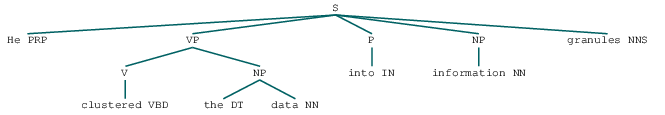

In [5]:
from IPython.display import display

display(syntax_tree)

## Dependency parsing


In [6]:
import spacy
from spacy import displacy

spacy_pipeline = spacy.load("en_core_web_sm")
sentence_output = spacy_pipeline(
    "Innopolis University is a university located in the city of Innopolis."
)

displacy.render(
    sentence_output,
    jupyter=True,
    options={"distance": 110, "arrow_stroke": 2, "arrow_width": 8},
)

## Constituency Parsing


In [7]:
%%capture
!wget https://nlp.stanford.edu/software/stanford-parser-4.2.0.zip
!unzip stanford-parser-4.2.0.zip

In [8]:
from nltk.parse.stanford import StanfordParser


scp = StanfordParser(
    "/kaggle/working/stanford-parser-full-2020-11-17/stanford-parser.jar",
    "/kaggle/working/stanford-parser-full-2020-11-17/stanford-parser-4.2.0-models.jar",
)

sentence = "Innopolis University is a university located in the city of Innopolis."

result = list(scp.raw_parse(sentence))
print(result[0])

(ROOT

  (S

    (NP (NNP Innopolis) (NNP University))

    (VP

      (VBZ is)

      (NP

        (NP (DT a) (NN university))

        (VP

          (VBN located)

          (PP

            (IN in)

            (NP

              (NP (DT the) (NN city))

              (PP (IN of) (NP (NNP Innopolis))))))))

    (. .)))


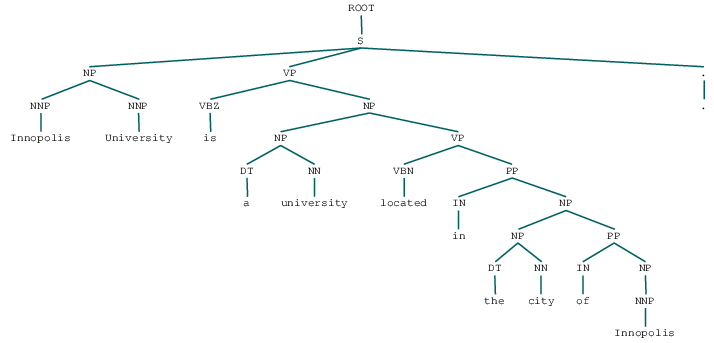

In [9]:
display(result[0])

## Task

Task is to classify medical transcription into types of medical speciality with use of dependency parsing.


In [10]:
import pandas as pd
import spacy
import re
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn import preprocessing

### Data


In [11]:
df = pd.read_csv("train.csv")
df.head()

,id,medical_specialty,transcription
0,0,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSIS: , Persistent pneumonia..."
1,1,General Medicine,"REASON FOR VISIT: , Mr. ABC is a 30-year-old m..."
2,2,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION: , Mesothelioma.,HISTO..."
3,3,General Medicine,"DISCHARGE DIAGNOSES:,1. Chronic obstructive pu..."
4,4,Cardiovascular / Pulmonary,"CHIEF COMPLAINT:, The patient complains of che..."


### Dependency parsing


In [12]:
spacy_pipeline = spacy.load("en_core_web_sm")

### Selected roles

- `nsubj` - nominal subject
- `root` - root
- `dobj` - direct object
- `nmod` - modifier of nominal
- `amod` - adjectival modifier
- `pobj` - object of preposition
- `appos` - appositional modifier


In [14]:
suitable_labels = ["nsubj", "root", "dobj", "nmod", "amod", "pobj", "appos"]

In [15]:
spacy_doc = spacy_pipeline(df.iloc[0]["transcription"])
print([(token, token.dep_) for token in spacy_doc])
print()
print([token for token in spacy_doc if token.dep_ in suitable_labels])

[(PREOPERATIVE, 'amod'), (DIAGNOSIS, 'ROOT'), (:, 'punct'), (,, 'punct'), (Persistent, 'compound'), (pneumonia, 'appos'), (,, 'punct'), (right, 'amod'), (upper, 'amod'), (lobe, 'appos'), (of, 'prep'), (the, 'det'), (lung, 'pobj'), (,, 'punct'), (possible, 'amod'), (mass, 'conj'), (., 'punct'), (,POSTOPERATIVE, 'punct'), (DIAGNOSIS, 'appos'), (:, 'punct'), (,, 'punct'), (Persistent, 'compound'), (pneumonia, 'appos'), (,, 'punct'), (right, 'amod'), (upper, 'amod'), (lobe, 'appos'), (of, 'prep'), (the, 'det'), (lung, 'pobj'), (,, 'punct'), (possible, 'amod'), (mass, 'appos'), (., 'punct'), (,PROCEDURE, 'dep'), (:, 'punct'), (,, 'punct'), ( , 'dep'), (Bronchoscopy, 'ROOT'), (with, 'prep'), (brush, 'compound'), (biopsies, 'pobj'), (., 'punct'), (,DESCRIPTION, 'punct'), (OF, 'prep'), (PROCEDURE, 'pobj'), (:, 'punct'), (,, 'punct'), (After, 'prep'), (obtaining, 'pcomp'), (an, 'det'), (informed, 'amod'), (consent, 'dobj'), (,, 'punct'), (the, 'det'), (patient, 'nsubjpass'), (was, 'auxpass'), (

### Preprocess data


In [16]:
df["processed"] = df["transcription"].apply(
    lambda x: [
        token
        for token in spacy_pipeline(re.sub(r"\b[A-Z]+\b", "", str(x)).lower())
        if token.dep_ in suitable_labels
    ]
)

In [17]:
le = preprocessing.LabelEncoder()
le.fit(df["medical_specialty"])
df["class_id"] = le.transform(df["medical_specialty"])
df.head()

,id,medical_specialty,transcription,processed,class_id
0,0,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSIS: , Persistent pneumonia...","[persistent, right, upper, lung, possible, per...",0
1,1,General Medicine,"REASON FOR VISIT: , Mr. ABC is a 30-year-old m...","[mr, ., old, who, followup, still, moderate, s...",3
2,2,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION: , Mesothelioma.,HISTO...","[patient, old, pleasant, caucasian, me, previo...",0
3,3,General Medicine,"DISCHARGE DIAGNOSES:,1. Chronic obstructive pu...","[chronic, obstructive, pulmonary, acute, hyper...",3
4,4,Cardiovascular / Pulmonary,"CHIEF COMPLAINT:, The patient complains of che...","[patient, pain, patient, old, who, he, previou...",0


### Create vocab


In [18]:
MAX_TOKENS = 5000


def yield_data(df):
    for _, row in df.iterrows():
        yield list([str(el) for el in row["processed"]])

In [19]:
vocab = build_vocab_from_iterator(
    yield_data(df),
    specials=["<unk>"],
    max_tokens=MAX_TOKENS,
)
vocab.set_default_index(vocab["<unk>"])

In [20]:
idx2symbol = vocab.get_itos()
symbol2idx = vocab.get_stoi()

### Create dataloader


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_pipeline = lambda x: [vocab([token.text for token in x])]


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for text, label in batch:
        label_list.append(label)
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)[0]
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


train_data = list(zip(df["processed"], df["class_id"]))
dataloader = DataLoader(
    train_data, batch_size=8, shuffle=False, collate_fn=collate_batch
)

### Create model


In [22]:
INIT_RANGE = 0.5


class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-INIT_RANGE, INIT_RANGE)
        self.fc.weight.data.uniform_(-INIT_RANGE, INIT_RANGE)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [23]:
model = TextClassificationModel(
    vocab_size=len(vocab), embed_dim=64, num_class=len(le.classes_)
).to(device)

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [25]:
EPOCHS = 30
for epoch in range(EPOCHS):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    tqdm_pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for idx, (label, text, offsets) in tqdm_pbar:
        optimizer.zero_grad()
        predicted_label = model(text, offsets)

        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()

        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        tqdm_pbar.set_description(
            f"Epoch {epoch}, accuracy: {total_acc/total_count:.3f}"
        )
    total_acc, total_count = 0, 0

    scheduler.step()

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

### Perform prediction


In [26]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,transcription
0,0,"INDICATIONS FOR PROCEDURE:, The patient has pr..."
1,1,"CLINICAL HISTORY: ,This 78-year-old black woma..."
2,2,"PREOPERATIVE DIAGNOSIS: , Penoscrotal abscess...."
3,3,"INDICATIONS:, Ischemic cardiomyopathy, status..."
4,4,"PREOPERATIVE DIAGNOSIS: , Ruptured distal bice..."


In [27]:
test_df["processed"] = test_df["transcription"].apply(
    lambda x: [
        token
        for token in spacy_pipeline(re.sub(r"\b[A-Z]+\b", "", str(x)).lower())
        if token.dep_ in suitable_labels
    ]
)

In [28]:
test_df["class_id"] = test_df["processed"].apply(
    lambda x: torch.argmax(
        model(torch.tensor(text_pipeline(x), dtype=torch.int64)[0], torch.tensor([0]))
    ).item()
)

In [29]:
test_df.head()

,id,transcription,processed,class_id
0,0,"INDICATIONS FOR PROCEDURE:, The patient has pr...","[patient, atypical, type, right, discomfort, s...",4
1,1,"CLINICAL HISTORY: ,This 78-year-old black woma...","[old, black, woman, history, hypertension, oth...",4
2,2,"PREOPERATIVE DIAGNOSIS: , Penoscrotal abscess....","[abscess, abscess, abscess, urethral, patient,...",4
3,3,"INDICATIONS:, Ischemic cardiomyopathy, status...","[status, post, inferior, myocardial, infarctio...",4
4,4,"PREOPERATIVE DIAGNOSIS: , Ruptured distal bice...","[distal, tendon, right, elbow, distal, tendon,...",4
